# GRAD-CAM


Saving n04065272_recreational_vehicle.jpg to n04065272_recreational_vehicle.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will 

Predicted class: recreational vehicle (757)


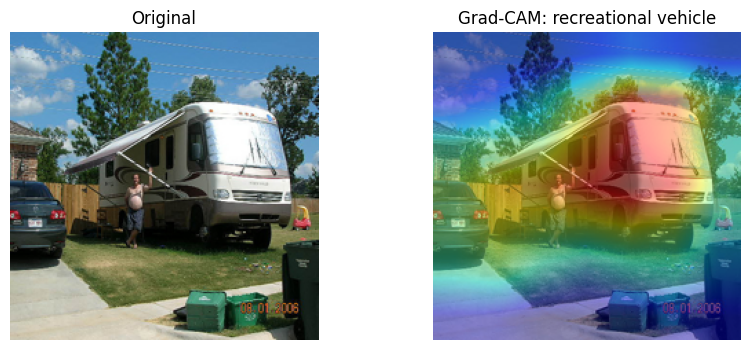

In [1]:
# Imports and Setup
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from google.colab import files
import urllib

# Upload image
uploaded = files.upload()
image = Image.open(list(uploaded.keys())[0]).convert('RGB')

# Preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load pretrained model
model = models.resnet18(pretrained=True)
model.eval()

# Register hooks
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Run prediction
output = model(input_tensor)
pred_class = output.argmax().item()
score = output[0, pred_class]
score.backward()

# Load ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
labels = urllib.request.urlopen(LABELS_URL).read().decode('utf-8').split('\n')
pred_label = labels[pred_class]
print(f"Predicted class: {pred_label} ({pred_class})")

# Generate Grad-CAM heatmap
grad = gradients[0].squeeze(0).detach()
act = activations[0].squeeze(0).detach()
weights = grad.mean(dim=(1, 2))

cam = torch.zeros(act.shape[1:], dtype=torch.float32)
for i, w in enumerate(weights):
    cam += w * act[i]

cam = torch.relu(cam)
cam -= cam.min()
cam /= cam.max()
cam_np = cam.numpy()

# Overlay on original image
heatmap = cv2.resize(cam_np, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img_np = np.array(image.resize((224, 224)))[:, :, ::-1]  # RGB to BGR
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Show results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image.resize((224, 224)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM: {pred_label}")
plt.imshow(overlay[:, :, ::-1])  # Convert BGR back to RGB
plt.axis('off')
plt.show()


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=205d70cf985ce46f79c3fbe101bb94d9940d51956a9df0d71dce615dc079a47b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# LIME Code

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

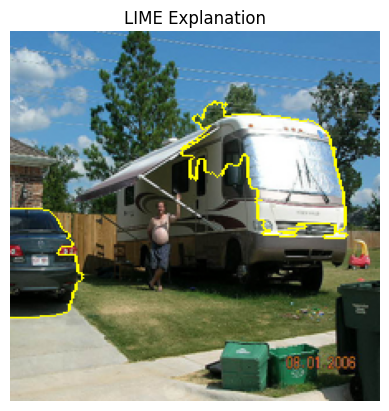

In [3]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load and preprocess image
image = Image.open(list(uploaded.keys())[0]).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Load pretrained model
model = resnet18(pretrained=True)
model.eval()

# Define prediction function for LIME
def predict(images):
    batch = []
    for img in images:
        img = Image.fromarray(img)
        t = transform(img).unsqueeze(0)
        batch.append(t)
    batch_tensor = torch.cat(batch)
    with torch.no_grad():
        outputs = model(batch_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).numpy()
    return probs

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
explanation = explainer.explain_instance(
    np.array(image.resize((224, 224))),
    predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Visualise explanation for top class
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)

# Display result
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()


# SHAP attempt #1

In [4]:
!pip install shap

Please upload your recreational vehicle image (will be resized to 224x224)


Saving n04065272_recreational_vehicle.jpg to n04065272_recreational_vehicle (3).jpg


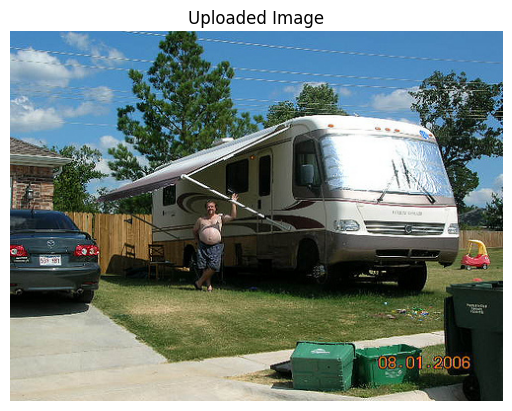

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


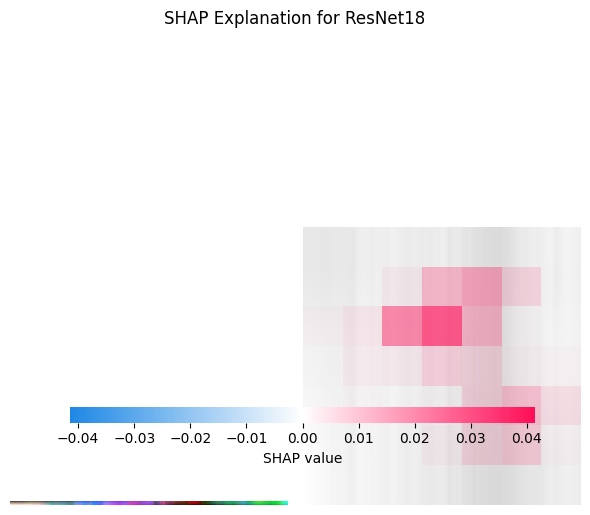

In [8]:
# Imports
import shap
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

%matplotlib inline

print("Please upload your recreational vehicle image (will be resized to 224x224)")
uploaded = files.upload()

# Get the first uploaded file
image_path = next(iter(uploaded))
image = Image.open(image_path).convert('RGB')

# Show the uploaded image
plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# Preprocess
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Load pretrained model
model = models.resnet18(pretrained=True).eval()

# Create SHAP explainer
layer = model.layer4[1].conv2

# Define a function to get model outputs
def model_forward(x):
    with torch.no_grad():
        output = model(x)
    return output

# Create background (using multiple black images works better than a single one)
background = torch.zeros((10, 3, 224, 224))

# SHAP: Use GradientExplainer
explainer = shap.GradientExplainer(
    (model, layer),
    background,
    local_smoothing=1
)

# Calculate SHAP values
shap_values, indexes = explainer.shap_values(
    input_tensor,
    ranked_outputs=1,
    nsamples=200
)

# Visualize
# Get the original image without normalization for display
unnormalized = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(image).unsqueeze(0)

shap.image_plot(
    [shap_values[0]],
    unnormalized.numpy(),
    show=False
)

# Show the plot with a title
plt.suptitle("SHAP Explanation for ResNet18", y=1.02)
plt.tight_layout()
plt.show()

# SHAP attempt #2 with prediction overlay

Please upload your recreational vehicle image


Saving n04065272_recreational_vehicle.jpg to n04065272_recreational_vehicle (4).jpg


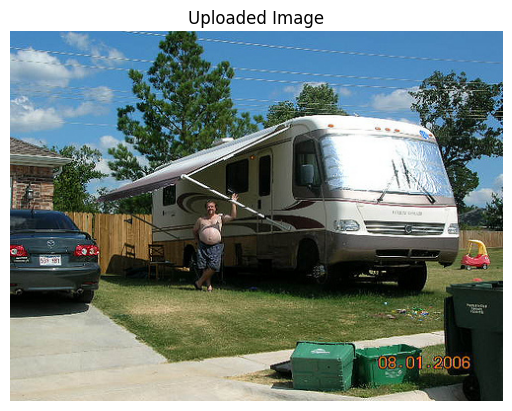

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



SHAP Explanation Overlay:


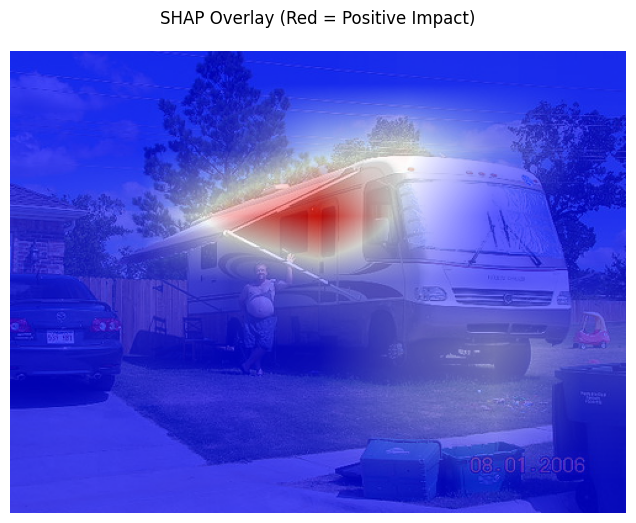


Predicted class index: 757


In [9]:
# Imports
import shap
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import cv2
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

print("Please upload your recreational vehicle image")
uploaded = files.upload()
image_path = next(iter(uploaded))
original_image = Image.open(image_path).convert('RGB')

# Show the uploaded image
plt.imshow(original_image)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# Preprocess
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(original_image).unsqueeze(0)

model = models.resnet18(pretrained=True).eval()

layer = model.layer4[1].conv2

background = torch.zeros((10, 3, 224, 224))

explainer = shap.GradientExplainer(
    (model, layer),
    background,
    local_smoothing=1
)

shap_values, indexes = explainer.shap_values(
    input_tensor,
    ranked_outputs=1,
    nsamples=200
)

# Custom visualization with overlay
def overlay_shap_on_image(shap_values, original_image, alpha=0.7):
    # Convert SHAP values to a heatmap
    shap_heatmap = np.sum(shap_values, axis=3)[0]
    shap_heatmap = (shap_heatmap - shap_heatmap.min()) / (shap_heatmap.max() - shap_heatmap.min())

    # Resize heatmap to match original image
    heatmap_resized = cv2.resize(shap_heatmap, (original_image.width, original_image.height))
    heatmap_resized = (heatmap_resized * 255).astype(np.uint8)

    # Create color-mapped heatmap
    cmap = LinearSegmentedColormap.from_list("shap", ["blue", "white", "red"])
    colored_heatmap = (cmap(heatmap_resized)[:, :, :3] * 255).astype(np.uint8)

    # Convert original image to numpy array
    img_array = np.array(original_image)

    # Overlay heatmap
    overlayed = cv2.addWeighted(colored_heatmap, alpha, img_array, 1 - alpha, 0)

    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(overlayed)
    plt.axis('off')
    plt.title("SHAP Overlay (Red = Positive Impact)", pad=20)
    plt.show()

# Generate overlay
print("\nSHAP Explanation Overlay:")
overlay_shap_on_image(shap_values[0], original_image)

# Show predicted class
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    print(f"\nPredicted class index: {predicted.item()}")